In [ ]:
!gdown 198uCuLf26DkECPvHS8GaDM7TD8sQ9RLh
!gdown 1OtHiSNb34oRptjsl-CohoRCGISRKVLaq

Downloading...
From: https://drive.google.com/uc?id=198uCuLf26DkECPvHS8GaDM7TD8sQ9RLh
To: /content/labels-20250212T103318Z-001.zip
100% 3.63M/3.63M [00:00<00:00, 23.3MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1OtHiSNb34oRptjsl-CohoRCGISRKVLaq
From (redirected): https://drive.google.com/uc?id=1OtHiSNb34oRptjsl-CohoRCGISRKVLaq&confirm=t&uuid=bbba059b-adb9-4836-b7d6-5d25006c90fb
To: /content/image_chips_native-20250212T103727Z-001.zip
100% 891M/891M [00:11<00:00, 76.0MB/s]


In [ ]:
!unzip -q /content/image_chips_native-20250212T103727Z-001.zip
!unzip -q /content/labels-20250212T103318Z-001.zip

In [ ]:
# Import required libraries
import os
import shutil
import random
import numpy as np
import pandas as pd
from PIL import Image,ImageDraw
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Implementing the Fundamental Functions

## 1. Write a function to compute IoU

Write a function to compute IoU (Intersection over Union) https://pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection/ between two axis-aligned bounding boxes specified in the Ultralytics YOLO format. You MUST use the shapely library [https://pypi.org/project/shapely/] and its functionalities to write your function. Show that your function provides the same or similar answer as IoU computed using `supervision` library

In [ ]:
!pip install -q -U shapely supervision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.5/181.5 kB 4.2 MB/s eta 0:00:00


In [ ]:
from shapely import box
from shapely.plotting import plot_polygon,plot_points
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
from supervision.detection.utils import box_iou_batch

In [ ]:
def preprocess_coords(bbox_1:list,bbox_2:list):
  # YOLO format is (x_center,y_center,width,height)
  x1,y1,w1,h1 = tuple(bbox_1)
  x2,y2,w2,h2 = tuple(bbox_2)

  x1_min = (x1 - w1/2)
  y1_min = (y1 - h1/2)
  x1_max = (x1 + w1/2)
  y1_max = (y1 + h1/2)

  x2_min = (x2 - w2/2)
  y2_min = (y2 - h2/2)
  x2_max = (x2 + w2/2)
  y2_max = (y2 + h2/2)

  return np.array([x1_min,y1_min,x1_max,y1_max]),np.array([x2_min,y2_min,x2_max,y2_max])

In [ ]:
from shapely.set_operations import intersection,union
def IOU(bbox_1, bbox_2, is_yolo: bool = False):

    # Convert YOLO format to min-max bounding boxes if needed
    if is_yolo:
        bbox_1, bbox_2 = preprocess_coords(bbox_1, bbox_2)


    b1 = box(bbox_1[0], bbox_1[1], bbox_1[2], bbox_1[3])
    b2 = box(bbox_2[0], bbox_2[1], bbox_2[2], bbox_2[3])
    intersection_area = intersection(b1,b2).area
    union_area = union(b1,b2).area

    return intersection_area / union_area


bbox1 = [0,0,3,3]
bbox2 = [1,1,2,2]

print(f" The IOU score obtained thorugh the function implementation is: {IOU(bbox1,bbox2,is_yolo=False)}")

bbox1_processed = np.expand_dims(bbox1,axis=0)
bbox2_processed = np.expand_dims(bbox2,axis=0)
print(f" The IOU score obtained through supervision library implementation is : {box_iou_batch(bbox1_processed,bbox2_processed)[0][0]}")

 The IOU score obtained thorugh the function implementation is: 0.1111111111111111
 The IOU score obtained through supervision library implementation is : 0.1111111111111111


## 2. Write a function to compute Average Precision (AP)

### a. Use Pascal VOC 11 point interpolation method to implement the function

In [ ]:
def compute_pascal_11_points(precision,recall):

  precision = np.array(precision)
  recall = np.array(recall)

  recall = np.concatenate(([0.0],recall,[1.0]))
  precision = np.concatenate(([1.0],precision,[0.0]))

  max_accumulated_precision = np.flip(np.maximum.accumulate(np.flip(precision)))

  interpolated_recall = np.linspace(0,1,11)

  interpolated_precision = np.interp(interpolated_recall,recall,max_accumulated_precision)

  return np.round(np.trapz(interpolated_precision,interpolated_recall),4)

### b. Use COCO 101-point interpolation method to implement the function

In [ ]:
def compute_coco_101_point(precision,recall):

  precision = np.array(precision)
  recall = np.array(recall)

  recall = np.concatenate(([0.0], recall, [1.0]))
  precision = np.concatenate(([1.0], precision, [0.0]))

  max_accumulated_precision = np.flip(np.maximum.accumulate(np.flip(precision)))

  interpolated_recall = np.linspace(0,1,101)

  interpolated_precision = np.interp(
      interpolated_recall,recall,max_accumulated_precision
  )
  return np.round(np.trapz(interpolated_precision,interpolated_recall),4)

### c. Use Area under Precision-Recall Curve (AP) method to implement the function

In [ ]:
def precision_recall_curve(precision,recall):

  precision = np.array(precision)
  recall = np.array(recall)

  recall = np.concatenate([[0],recall,[1]])
  precision = np.concatenate([[1],precision,[0]])

  max_accumulated_precision = np.flip(np.maximum.accumulate(np.flip(precision)))

  avg_precision = np.trapz(max_accumulated_precision,recall)

  return np.round(avg_precision,4)

In [ ]:
precision = [1,1,0.67,0.5,0.4,0.5,0.57]
recall = [0.2,0.4,0.4,0.4,0.4,0.6,0.8]

print(f" The Average Precision through Pascal VOC 11 point interpolation method is: {compute_pascal_11_points(precision,recall)}")
print(f" The Average Precision through COCO 101 point interpolation method is: {compute_coco_101_point(precision,recall)}")
print(f" The Average Precision through Area under Precision-Recall Curve method is: {precision_recall_curve(precision,recall)}")

 The Average Precision through Pascal VOC 11 point interpolation method is: 0.6635
 The Average Precision through COCO 101 point interpolation method is: 0.6829
 The Average Precision through Area under Precision-Recall Curve method is: 0.685


#### **d.** Randomly generate 10 images of size 100x100. Randomly generate 10 ground truth boxes of size 20x20 and 10 predicted boxes of size 20x20 in each image. Assume there is only one class of objects. Compare the AP50 (Average Precision at IoU 0.5) computed by 3 of your methods

###### **NOTE:** Lets define `helper functions` to achieve the task specified above

In [ ]:
# Generate a random image of specified shape
def generate_random_image(img_height: int, img_width: int):
    return np.full((img_height, img_width, 3), 240).astype(np.uint8)


# Generate random ground truth and prediction boxes (requires img_size and box_size)
def generate_random_boxes(img_size, box_size, overlap_ratio):
    x1_min = np.random.randint(int(img_size * 0.1), int(img_size * 0.7))
    y1_min = np.random.randint(int(img_size * 0.1), int(img_size * 0.7))
    x1_max = min(x1_min + box_size, img_size)
    y1_max = min(y1_min + box_size, img_size)

    x_diff = x1_max - x1_min
    y_diff = y1_max - y1_min

    overlap_x = int(x_diff * overlap_ratio)
    overlap_y = int(y_diff * overlap_ratio)

    x_shift = np.random.choice([-1, 1]) * (x_diff - overlap_x)
    y_shift = np.random.choice([-1, 1]) * (y_diff - overlap_y)

    x2_min = max(0, min(x1_min + x_shift, img_size - box_size))
    y2_min = max(0, min(y1_min + y_shift, img_size - box_size))
    x2_max = min(x2_min + box_size, img_size)
    y2_max = min(y2_min + box_size, img_size)

    return [x1_min, y1_min, x1_max, y1_max], [x2_min, y2_min, x2_max, y2_max]

In [ ]:
# Draw the generated prediction and truth boxes on the image and return the image
def draw_boxes(img, true_boxes, predicted_boxes):
    img = Image.fromarray(np.squeeze(img))
    draw = ImageDraw.Draw(img)

    for true_box, predicted_box in zip(true_boxes, predicted_boxes):
        draw.rectangle([true_box[0], true_box[1], true_box[2], true_box[3]], outline="red", width=1)
        draw.rectangle([predicted_box[0], predicted_box[1], predicted_box[2], predicted_box[3]], outline="blue", width=1)

    return img

In [ ]:
# Generates images based on the n_images --> number of images to generate and returns the images
def generate_images(n_images: int = 10, img_size: int = 100, box_size: int = 20, n_boxes: int = 10):
    images = []
    all_ground_truth_bboxes = []
    all_predicted_bboxes = []

    for _ in range(n_images):
        ground_truth_bboxes = []
        predicted_bboxes = []
        img = generate_random_image(img_size, img_size)

        for _ in range(n_boxes):
            overlap_factor = np.random.choice(np.linspace(0.4, 1.0, 10))
            true_box, pred_box = generate_random_boxes(img_size, box_size, overlap_factor)
            ground_truth_bboxes.append(true_box)
            predicted_bboxes.append(pred_box)

        img = draw_boxes(img, ground_truth_bboxes, predicted_bboxes)
        images.append(img)
        all_ground_truth_bboxes.append(ground_truth_bboxes)
        all_predicted_bboxes.append(predicted_bboxes)

    return images, all_ground_truth_bboxes, all_predicted_bboxes

In [ ]:
# plots the images along with their ground truth and predicted boxes
def plot_images_boxes(images):
  plt.figure(figsize=(15, 8))
  for i, img in enumerate(images):
    plt.subplot(2, 5, i + 1)
    plt.imshow(img)


    plt.xticks([])
    plt.yticks([])

  plt.subplots_adjust(wspace=0.05, hspace=0)
  plt.show()

In [ ]:
images, ground_truth_bbox, predicted_bbox = generate_images(n_images=10)

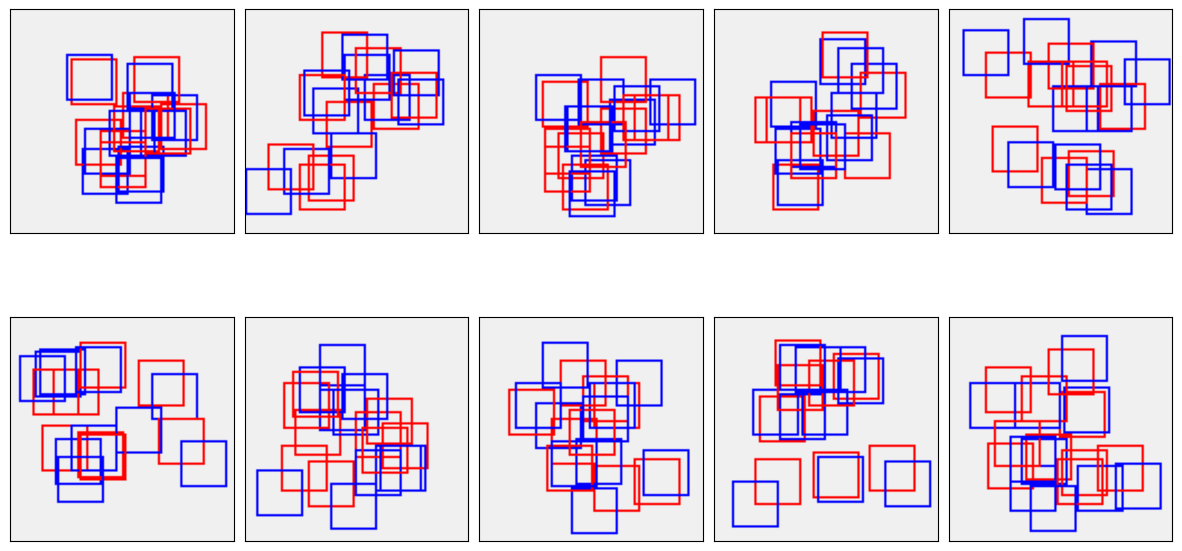

In [ ]:
plot_images_boxes(images)

In [ ]:
def calculate_precision_recall(gt_boxes, pred_boxes, iou_threshold=0.5):
    TP = 0
    matched_gt = set()

    for pred in pred_boxes:
        best_iou = 0
        best_gt_idx = -1
        for i, gt in enumerate(gt_boxes):
            iou = IOU(pred, gt)
            if iou > best_iou:
                best_iou = iou
                best_gt_idx = i

        if best_iou >= iou_threshold and best_gt_idx not in matched_gt:
            TP += 1
            matched_gt.add(best_gt_idx)

    FP = len(pred_boxes) - TP
    FN = len(gt_boxes) - len(matched_gt)

    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    recall = TP / (TP + FN) if (TP + FN) > 0 else 0

    return precision, recall

In [ ]:
precisions = []
recalls = []
for gt,pred in zip(ground_truth_bbox,predicted_bbox):
  precision,recall = calculate_precision_recall(gt,pred)
  precisions.append(precision)
  recalls.append(recall)

In [ ]:
print(f" The AP50 obtained using Pascal VOC 11 point interpolation is: {compute_pascal_11_points(precisions,recalls)}")
print(f" The AP50 obtained using COCO 101 point interpolation is: {compute_coco_101_point(precisions,recalls)}")
print(f" The AP50 obtained using Area under Precision-Recall Curve is: {precision_recall_curve(precisions,recalls)}")

 The AP50 obtained using Pascal VOC 11 point interpolation is: 0.4929
 The AP50 obtained using COCO 101 point interpolation is: 0.5121
 The AP50 obtained using Area under Precision-Recall Curve is: 0.45
